In [19]:
import dowhy
from dowhy import CausalModel
from sklearn.ensemble import RandomForestRegressor

import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
from sys import path
import os

for dirname, _, filenames in os.walk("../../../resources/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path.append(os.path.realpath("../../../"))

from custom import functions

warnings.filterwarnings("ignore")

../../../resources/allColProSol.xlsx
../../../resources/dataset_a_2021.csv
../../../resources/dataset_a_2021c2.csv
../../../resources/dataset_a_2021v1.xlsx
../../../resources/dataset_unab_ORIGINAL SIN P1.csv
../../../resources/dataset_unab_P1.csv
../../../resources/exitoFallidoEnviosProgramaSol.xlsx
../../../resources/exitoFallidoProgramaSol.xlsx
../../../resources/exitosoFallidosEnviosAllColProSol.xlsx
../../../resources/exitosoFallidosEnviosAllColSol.xlsx
../../../resources/exitososFallidosEnviosSol.xlsx
../../../resources/Hito12sinColCeroExitosoFallidosSol.xlsx
../../../resources/sinColCeroExitosoFallidosEnviosSol.xlsx
../../../resources/sinColCeroExitosoFallidosSol.xlsx
../../../resources/v2_hitosExitoFalloColESol1.csv
../../../resources/v2_hitosExitoFalloColESol1Prograna.csv
../../../resources/v2_hitosExitoFalloSol1Programa.csv
../../../resources/causalidad\causalidad.dot
../../../resources/causalidad\causalidad.png
../../../resources/causalidad\causalidad_e29.dot
../../../resourc

In [20]:
# Read and preview data
df = pd.read_csv(
    "../../../resources/v2_hitosExitoFalloColESol1.csv",
    delimiter=";",
    skipinitialspace=True,
)

In [21]:
# creando columna aprobado y con la funcion set_in_aprobado_nota poblamos la nueva columna.
df["aprobado"] = df.apply(lambda x: functions.set_in_aprobado_nota(x["sol1"]), axis=1)
# revisamos la existencia de la nueva columna.
print(df.columns)

Index(['hito1', 'hito2', 'exitosos', 'fallidos', 'e0', 'e1', 'e2', 'e3', 'e4',
       'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e14', 'e15',
       'e16', 'e17', 'e18', 'e19', 'e20', 'e21', 'e22', 'e23', 'e24', 'e25',
       'e26', 'e27', 'e28', 'e29', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35',
       'e36', 'e37', 'e38', 'e39', 'e40', 'e41', 'e42', 'e43', 'e44', 'e45',
       'e46', 'e47', 'e48', 'e49', 'e50', 'e51', 'e52', 'sol1', 'aprobado'],
      dtype='object')


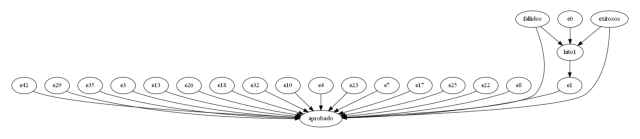

In [22]:
model = CausalModel(
    data=df,
    treatment="hito1",
    outcome="aprobado",
    graph="""
    digraph {
        hito1 -> e1; e1 -> aprobado;
        e42 -> aprobado;
        e29 -> aprobado;
        e35 -> aprobado;
        e3 -> aprobado;
        e13-> aprobado;
        e26-> aprobado;
        e18-> aprobado;
        e32-> aprobado;
        e10-> aprobado;
        e0 -> hito1;
        e4-> aprobado;
        e23-> aprobado;
        e7-> aprobado;
        e17-> aprobado;
        e25-> aprobado;
        e22-> aprobado;
        e8-> aprobado;
        fallidos -> hito1; fallidos -> aprobado;
        exitosos -> hito1; exitosos -> aprobado;
    }
    """,
)
# Visualizar el modelo causal con la variable de causa común no observada
model.view_model(
    layout="dot",
    file_name="../../../resources/causalidad/analisis_shap/graph_causal_model_hito1_notPrediction",
)

In [23]:
# Paso 2: Identificar el estimando objetivo bajo el modelo
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                   
────────(E[aprobado|fallidos,exitosos])
d[hito₁]                               
Estimand assumption 1, Unconfoundedness: If U→{hito1} and U→aprobado then P(aprobado|hito1,fallidos,exitosos,U) = P(aprobado|hito1,fallidos,exitosos)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                -1⎤
 ⎢  d             ⎛  d           ⎞  ⎥
E⎢─────(aprobado)⋅⎜─────([hito₁])⎟  ⎥
 ⎣d[e₀]           ⎝d[e₀]         ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→aprobado then ¬(U →→{e0})
Estimand assumption 2, Exclusion: If we remove {e0}→{hito1}, then ¬({e0}→aprobado)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡  d                d          ⎤
E⎢─────(aprobado)⋅────────([e₁])⎥
 ⎣d[e₁]           d[hito₁]      ⎦
Estimand assumption 1, Full-mediation: e1 intercepts (blocks) all directed paths from hito1 to

In [24]:
# Paso 3: Estimar el efecto causal usando un método basado en árboles
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value=0,
    treatment_value=1,
    target_units="ate",  # Average Treatment Effect
    method_params={
        "init_params": {
            "model_y": RandomForestRegressor(),
            "model_t": RandomForestRegressor(),
            "model_final": RandomForestRegressor(
                max_depth=10,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=1502,
                n_estimators=500,
            ),
            "featurizer": None,
        },
        "fit_params": {},
    },
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                   
────────(E[aprobado|fallidos,exitosos])
d[hito₁]                               
Estimand assumption 1, Unconfoundedness: If U→{hito1} and U→aprobado then P(aprobado|hito1,fallidos,exitosos,U) = P(aprobado|hito1,fallidos,exitosos)

## Realized estimand
b: aprobado~hito1+fallidos+exitosos | e32,e23,e42,e22,e4,e8,e26,e13,e18,e3,e35,e17,e25,e29,e7,e10
Target units: ate

## Estimate
Mean value: -0.143496443582768
Effect estimates: [[-1.53678476e-01]
 [-2.58716365e-02]
 [-1.84675659e-01]
 [-1.16525709e-01]
 [-1.16525709e-01]
 [-1.16525709e-01]
 [-1.16525709e-01]
 [-1.16525709e-01]
 [-1.16525709e-01]
 [-1.16525709e-01]
 [-1.16525709e-01]
 [-1.16525709e-01]
 [-1.16525709e-01]
 [-2.58716365e-02]
 [-1.16525709e-01]
 [-1.94320549e-01]
 [-1.16525709e-01]
 [-3.39041005e-01]
 [-1.16525709e-01]
 [-1.1652570

In [25]:
# Refutador de datos aleatorios
refute1 = model.refute_estimate(
    identified_estimand, estimate, method_name="random_common_cause"
)
print(refute1)

Refute: Add a random common cause
Estimated effect:-0.143496443582768
New effect:-0.06384941131912769
p value:0.32000000000000006



In [26]:
# Refutador de causa común no observada
refute2 = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.01,
    effect_strength_on_outcome=0.02,
)
print(refute2)

Refute: Add an Unobserved Common Cause
Estimated effect:-0.143496443582768
New effect:0.012117847032839801



In [27]:
# Paso 4: Refutar el estimado obtenido
refute3 = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
)
print(refute3)

Refute: Use a Placebo Treatment
Estimated effect:-0.143496443582768
New effect:0.0002960734337066002
p value:0.98



In [28]:
# Natural direct effect (nde)
identified_estimand_nde = model.identify_effect(
    estimand_type="nonparametric-nde",
    proceed_when_unidentifiable=True,
)
print(identified_estimand_nde)

Estimand type: EstimandType.NONPARAMETRIC_NDE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡   d                 ⎤
E⎢────────(aprobado|e1)⎥
 ⎣d[hito₁]             ⎦
Estimand assumption 1, Mediation: e1 intercepts (blocks) all directed paths from hito1 to a,p,r,o,b,a,d,o except the path {hito1}→{a,p,r,o,b,a,d,o}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{hito1} and U→{e1} then P(e1|hito1,U) = P(e1|hito1)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{e1} and U→aprobado then P(aprobado|e1, hito1, U) = P(aprobado|e1, hito1)



In [29]:
# Natural indirect effect (nie)
identified_estimand_nie = model.identify_effect(
    estimand_type="nonparametric-nie", proceed_when_unidentifiable=True
)
print(identified_estimand_nie)

Estimand type: EstimandType.NONPARAMETRIC_NIE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡  d                d          ⎤
E⎢─────(aprobado)⋅────────([e₁])⎥
 ⎣d[e₁]           d[hito₁]      ⎦
Estimand assumption 1, Mediation: e1 intercepts (blocks) all directed paths from hito1 to a,p,r,o,b,a,d,o except the path {hito1}→{a,p,r,o,b,a,d,o}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{hito1} and U→{e1} then P(e1|hito1,U) = P(e1|hito1)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{e1} and U→aprobado then P(aprobado|e1, hito1, U) = P(aprobado|e1, hito1)



In [30]:
causal_estimate_nde = model.estimate_effect(
    identified_estimand_nde,
    method_name="mediation.two_stage_regression",
    confidence_intervals=False,
    test_significance=False,
    method_params={
        "first_stage_model": dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
        "second_stage_model": dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
    },
)
print(causal_estimate_nde)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_NDE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡   d                 ⎤
E⎢────────(aprobado|e1)⎥
 ⎣d[hito₁]             ⎦
Estimand assumption 1, Mediation: e1 intercepts (blocks) all directed paths from hito1 to a,p,r,o,b,a,d,o except the path {hito1}→{a,p,r,o,b,a,d,o}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{hito1} and U→{e1} then P(e1|hito1,U) = P(e1|hito1)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{e1} and U→aprobado then P(aprobado|e1, hito1, U) = P(aprobado|e1, hito1)

## Realized estimand
(b: aprobado~hito1+fallidos+exitosos+hito1*e32+hito1*e23+hito1*e42+hito1*e22+hito1*e4+hito1*e8+hito1*e26+hito1*e13+hito1*e18+hito1*e3+hito1*e35+hito1*e17+hito1*e25+hito1*e29+hito1*e7+hito1*e10) - ((b: e1~hito1+hito1*e32+hito1*e23+hito1*e42+hito1*e22+hito1*e4+hito1*e8+hito1*e26+hito1*e13+hito1*e18+hito1*e3+hito1*e35+hito1*e17+hito1*e25+hito1*e29+hito1*

In [31]:
import dowhy.causal_estimators.linear_regression_estimator

causal_estimate_nie = model.estimate_effect(
    identified_estimand_nie,
    method_name="mediation.two_stage_regression",
    confidence_intervals=False,
    test_significance=False,
    method_params={
        "first_stage_model": dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
        "second_stage_model": dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
    },
)
print(causal_estimate_nie)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_NIE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡  d                d          ⎤
E⎢─────(aprobado)⋅────────([e₁])⎥
 ⎣d[e₁]           d[hito₁]      ⎦
Estimand assumption 1, Mediation: e1 intercepts (blocks) all directed paths from hito1 to a,p,r,o,b,a,d,o except the path {hito1}→{a,p,r,o,b,a,d,o}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{hito1} and U→{e1} then P(e1|hito1,U) = P(e1|hito1)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{e1} and U→aprobado then P(aprobado|e1, hito1, U) = P(aprobado|e1, hito1)

## Realized estimand
(b: e1~hito1+hito1*e32+hito1*e23+hito1*e42+hito1*e22+hito1*e4+hito1*e8+hito1*e26+hito1*e13+hito1*e18+hito1*e3+hito1*e35+hito1*e17+hito1*e25+hito1*e29+hito1*e7+hito1*e10)*(b: aprobado~e1+hito1+e1*e32+e1*e23+e1*e42+e1*e22+e1*e4+e1*e8+e1*e26+e1*e13+e1*e18+e1*e3+e1*e35+e1*e17+e1*e25+e1*e29+e1*e7+e1*e10)
Target units: ate

## Est